In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import builtins
builtins.NAMING = "new"


from plotting_src.header_settings import *
from plotting_src.read_ggp_run import * 
from simulations.cells_simulation import * 

from plotting_src.cells_utils import *
from plotting_src.read_utils import *


from plotting_src.plot_correlations_from_npz import *

%config InlineBackend.figure_format ='retina'

header_setting.py: using new naming


In [2]:
def calc_log_concentration(cells):
    for i, cell in enumerate(cells):
        c = cell.gfp/np.exp(cell.log_length)
        if np.any(c<0):
            print(c)
        cells[i].log_concentration = np.log(c)
        cells[i].log1_concentration = np.log(c+1)
        cells[i].concentration = c
    return cells


def calc_mean(means, covs=None):
    if np.any(covs==None):
        mean = np.mean(means)
    else:
        mean = np.sum(means/covs) /np.sum(1/covs)
    return mean


def calc_cv(means, covs=None):
    if np.any(covs==None):
        return np.std(means)/np.mean(means)
    else:
        return np.sqrt(np.sum(np.power(means, 2) + covs)/len(means) - np.mean(means)**2)/calc_mean(means)

    
def get_finite_log_concentrations(cells):
    lc = np.concatenate([cell.log_concentration for cell in cells])
    return lc[np.isfinite(lc)]


def estimate_iqr(c):
    return np.subtract(*np.percentile(c, [75, 25]))


def get_log_concentration_iqr(cells):
    return estimate_iqr( get_finite_log_concentrations(cells) )


def get_metas(prediction_files):
    prediction_files = sorted(prediction_files)
    samples = pd.DataFrame(index=prediction_files, columns=["gamma_lambda"])
    
    for pf in prediction_files:
        parameter_file = os.path.join(*pf.split("/")[:-1]) + '/parameters_simulation.txt'
        paramters = read_parameter_file(parameter_file)
        
        samples.loc[pf,"mean_lambda"] = paramters['mean_lambda'][1]
        samples.loc[pf,"gamma_lambda"] = paramters['gamma_lambda'][1]
        samples.loc[pf,"tau_lambda"] = 1./paramters['gamma_lambda'][1]
        samples.loc[pf,"tau2_lambda"] = np.log(2)/paramters['gamma_lambda'][1]
        samples.loc[pf,"Tdbl"] = np.log(2)/paramters['mean_lambda'][1]
        samples.loc[pf,"var_lambda"] = paramters['var_lambda'][1]        
        
        samples.loc[pf,"cv"] = np.sqrt(paramters['var_lambda'][1]/(2*paramters['gamma_lambda'][1]))/paramters['mean_lambda'][1]
    return samples.to_dict('index')



def get_cells(samples):
    for pf in samples.keys():
        samples[pf]["cells"] = calc_log_concentration(df2cells(read_ggp_csv(pf)))
        samples[pf]["log_conc_iqr"] = get_log_concentration_iqr(samples[pf]["cells"])

    return samples
        

input_dir_const_q = '../../fluctuations_paper_data/simulations/vary_cv_gamma_n5000_adder_const_q'
prediction_files_const_q = []
for i in range(49):
    sample = input_dir_const_q.split('/')[-1] + "_{:d}".format(i)
    prediction_files_const_q.append( os.path.join(input_dir_const_q, sample, sample +".csv" ))
         
samples_const_q = get_cells(get_metas(prediction_files_const_q))



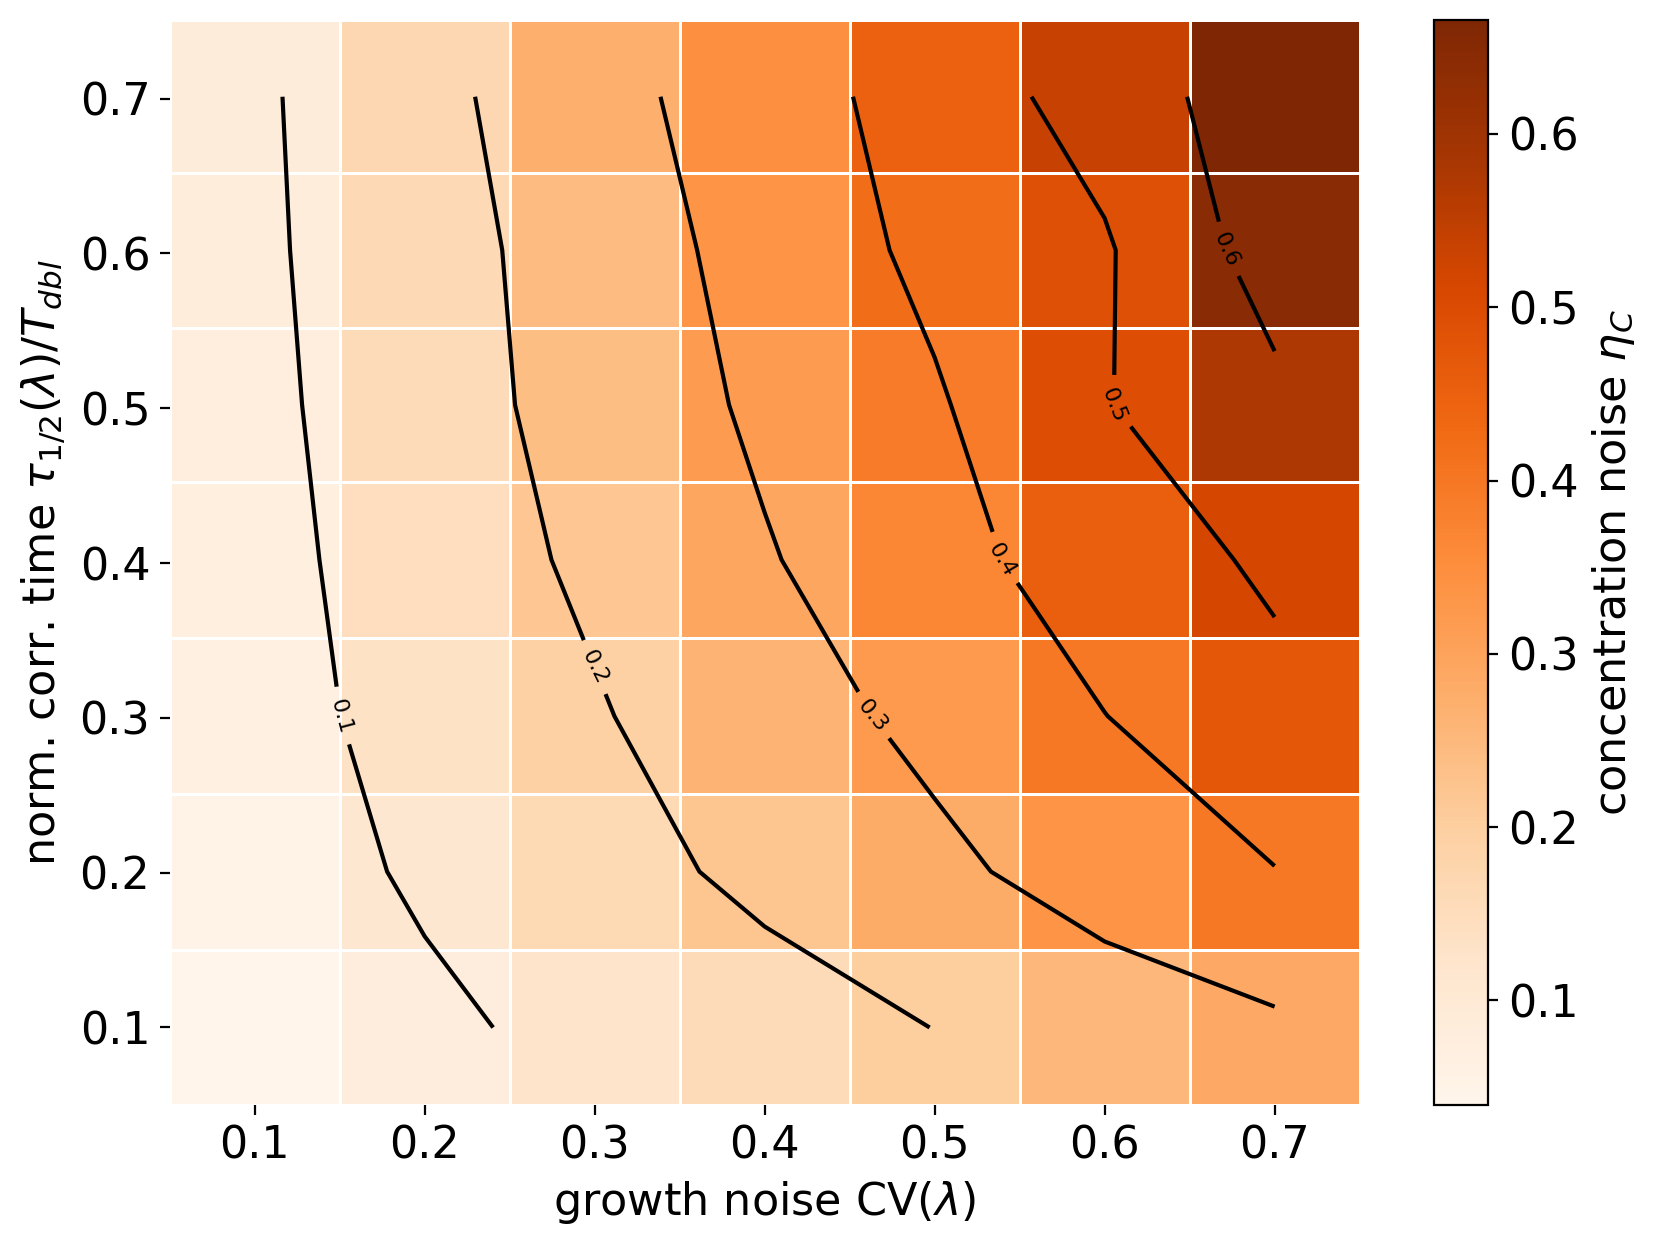

In [3]:
def plot_iqr_vs_cv_and_tau(samples, plot_file=None, title=None):
    fig, axes = plt.subplots(1,1, figsize=(FULL_SIZE*2/3., FULL_SIZE/2.))
    ax = [axes]
    
    for a in ax:
        a.spines["top"].set_visible(False)
        a.spines["bottom"].set_visible(False)
        
        a.spines["left"].set_visible(False)
        a.spines["right"].set_visible(False)

        a.spines['right'].set_color('none')
        a.spines['left'].set_color('none')
        

    d = {'tau2_lambda': [samples[sample]["tau2_lambda"]/samples[sample]["Tdbl"] for sample in samples.keys()],
         'cv': [samples[sample]["cv"] for sample in samples.keys() ],
         'log_conc_iqr': [samples[sample]["log_conc_iqr"] for sample in samples.keys()]}
    
    
    df = pd.DataFrame(data=d)
    df = df.sort_values(by=['tau2_lambda', 'cv'])
    cvs = np.unique(np.around(df["cv"], 2))
    taus = np.unique(np.around(df["tau2_lambda"], 5))

    log_conc_iqr = df["log_conc_iqr"].to_numpy().reshape(len(taus), len(cvs))
        
    p = axes.pcolormesh(cvs,taus,
                        log_conc_iqr, 
                        shading='nearest', 
                        cmap="Oranges",
                        edgecolors='w',lw=0.5)
    
    CS = axes.contour(cvs,taus, log_conc_iqr,  
                      np.arange(0.1, 0.7, 0.1), 
                      colors='k') 
    axes.clabel(CS, fontsize=8, inline=True)

    
    axes.set_xlabel(r"growth noise CV($\lambda$)")
    axes.set_ylabel(r"norm. corr. time $\tau_{1/2}(\lambda)/T_{dbl}$")
    axes.set_title(title)
    
    fig.colorbar(p, label="concentration noise $\eta_C$")
    
    plt.tight_layout()
    if plot_file !=None:
        fig.savefig(plot_file, facecolor="white", bbox_inches='tight')
    plt.show()
    
plot_iqr_vs_cv_and_tau(samples_const_q, 
                       title=None,
                       plot_file="../../figures_for_fluctuations_paper/supp/noise_vs_tau_and_cv_const_q.pdf")

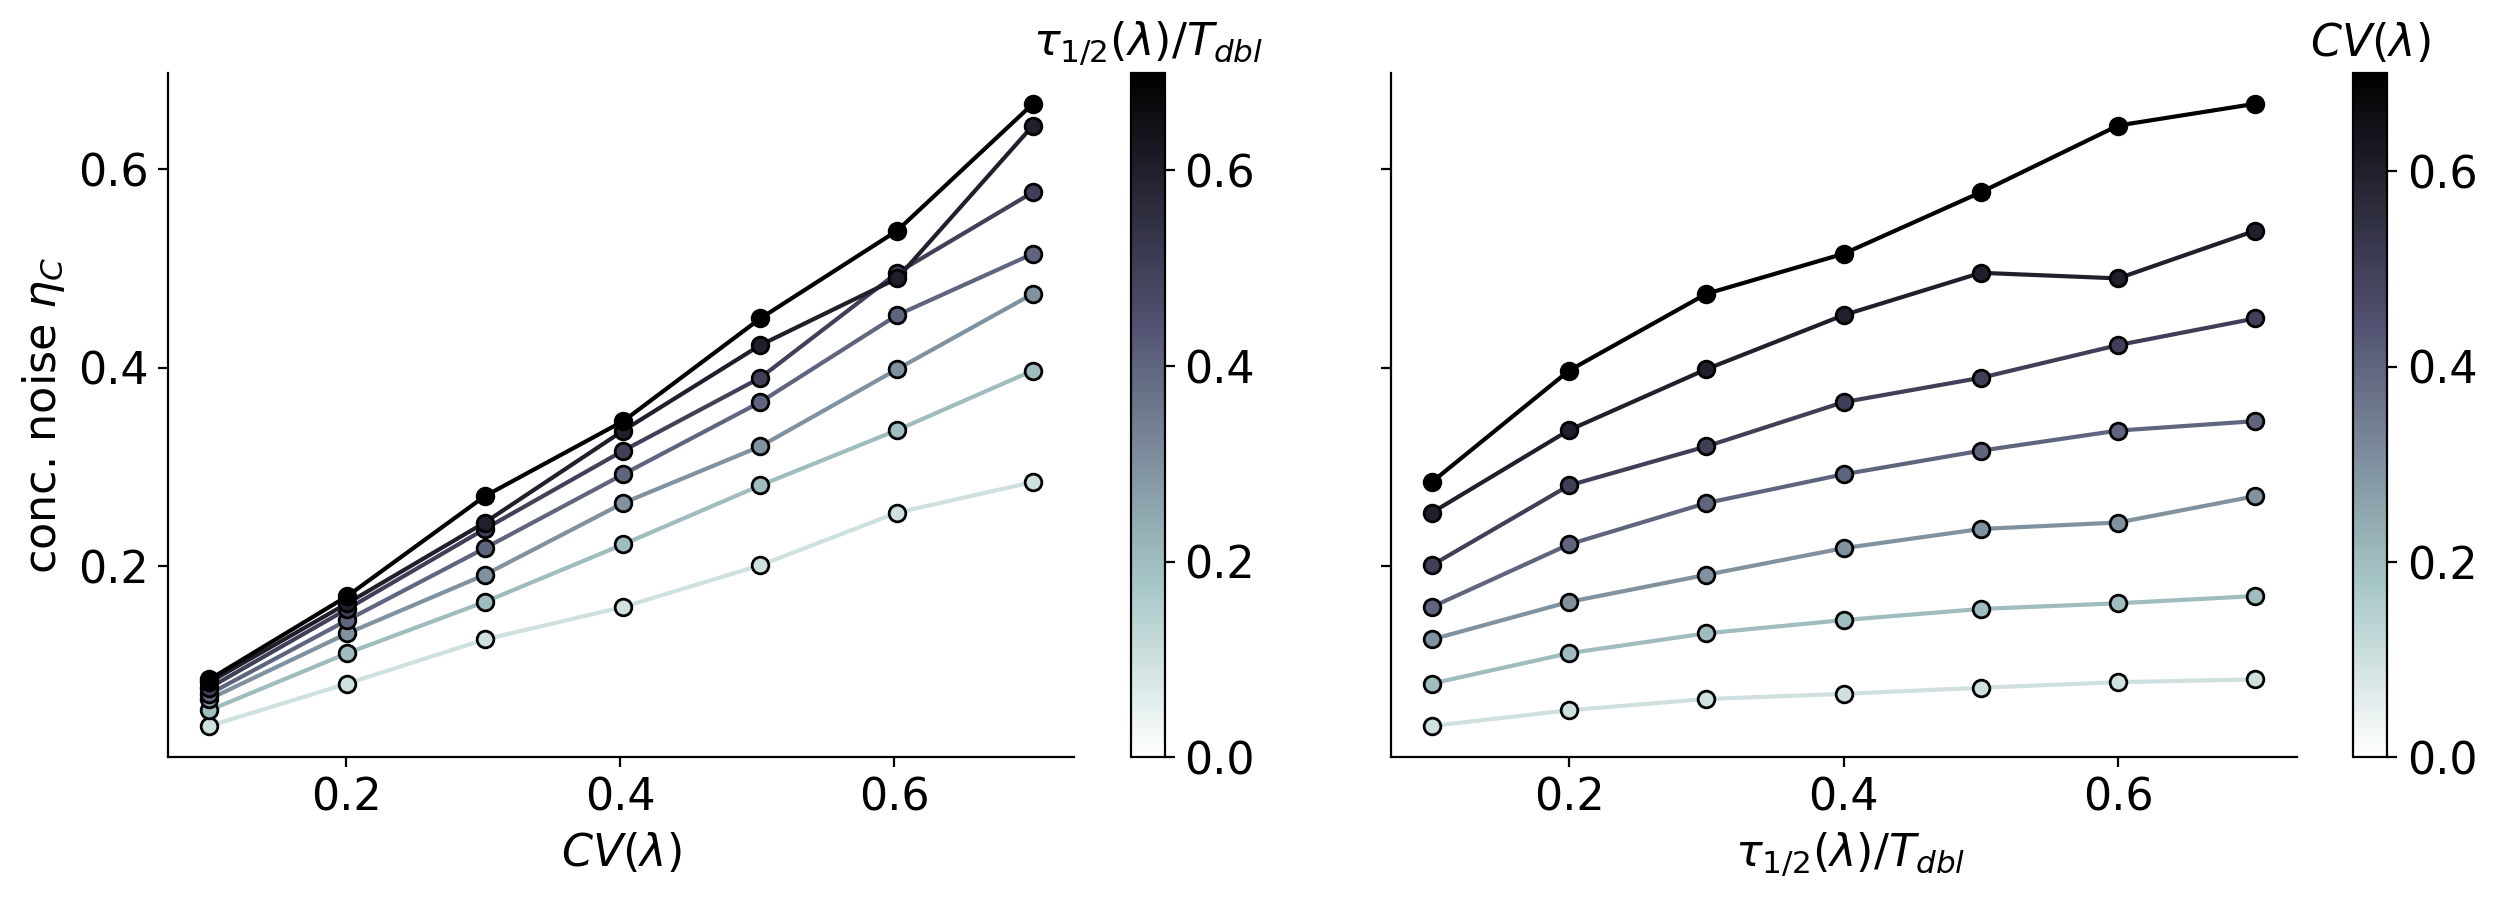

In [4]:
def plot_iqr_vs_cv_and_tau_lines(samples, xaxis, plot_file=None, title=None):
    fig, axes = plt.subplots(1,2, figsize=(FULL_SIZE, 5), sharey=True)
    ax = axes.ravel()
    
    for a in ax:
        a.spines["top"].set_visible(False)
        
        a.spines["right"].set_visible(False)

        a.spines['right'].set_color('none')
        

    d = {'tau2_lambda': [samples[sample]["tau2_lambda"]/samples[sample]["Tdbl"] for sample in samples.keys()],
         'cv': [samples[sample]["cv"] for sample in samples.keys() ],
         'log_conc_iqr': [samples[sample]["log_conc_iqr"] for sample in samples.keys()]}
    
    cmap = "bone_r"
    
    df = pd.DataFrame(data=d)
    cvs = np.unique(np.around(df["cv"], 2))
    taus = np.unique(np.around(df["tau2_lambda"], 5))
    
    ########################################################################
    log_conc_iqr = df.sort_values(by=['tau2_lambda', 'cv'])["log_conc_iqr"].to_numpy().reshape(len(taus), len(cvs))

    norm = matplotlib.colors.Normalize(vmin=0, vmax=np.max(cvs))
    ccolors = plt.get_cmap(cmap)

    for i, iqr in enumerate(log_conc_iqr):
        ax[0].plot(taus, iqr, color=ccolors(norm(cvs[i])), marker="o", markeredgecolor="black")


    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cax = fig.colorbar(sm, ax=ax[0], ticks=[0, 0.2, 0.4, 0.6])
    
    cax.ax.set_title(r"$\tau_{1/2}(\lambda)/T_{dbl}$")

    ax[0].set_xlabel(r"$CV(\lambda)$")
    ax[0].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=0.2))
    ax[0].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=0.2))
    
    ax[0].set_ylabel(r"conc. noise $\eta_C$")
    
    ########################################################################
    log_conc_iqr = df.sort_values(by=['tau2_lambda', 'cv'])["log_conc_iqr"].to_numpy().reshape(len(taus), len(cvs))
    norm = matplotlib.colors.Normalize(vmin=0, vmax=np.max(taus))
    ccolors = plt.get_cmap(cmap)

    for i, iqr in enumerate(log_conc_iqr.transpose()):
        ax[1].plot(cvs, iqr, color=ccolors(norm(taus[i])), marker="o", markeredgecolor="black")


    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cax = fig.colorbar(sm, ax=ax[1], ticks=[0, 0.2, 0.4, 0.6])
    cax.ax.set_title(r"$CV(\lambda)$")
    
    ax[1].set_xlabel(r" $\tau_{1/2}(\lambda)/T_{dbl}$")
    ax[1].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=0.2))
    ax[1].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=0.2))

    # ax[1].set_ylim(0.,0.8)
    
    ax[1].set_yticks([0.2, 0.4, 0.6])
    fig.suptitle(title, y=0.9)
            
    plt.tight_layout(w_pad=2)
    if plot_file !=None:
        fig.savefig(plot_file, facecolor="white", bbox_inches='tight')
    plt.show()
    
    
    
    
    
plot_iqr_vs_cv_and_tau_lines(samples_const_q, "cvs",
                       title=None,
                       plot_file="../../figures_for_fluctuations_paper/supp/noise_vs_tau_and_cv_const_q_lines.pdf")
